# The Most Complete Spotify Genre Analysis

![](https://images.unsplash.com/photo-1513829596324-4bb2800c5efb?ixlib=rb-1.2.1&auto=format&fit=crop&w=750&q=80)

### In this notebook, we will explore the hidden facts about Spotify genres and answer the following questions:

### * How do genres look like?

We will explore the hidden truths behind the data by creating
heatmaps, scatterplots, barplots, word cloud etc.

### * Can we predict genres at all?
 
We are gonna test the K-Nearest Neighbors and Cosine Similarity Algorithm
on how good they are at imputing missing genres

### * Can we cluster genres into bigger genre groups?

How could we teach machines to tell the difference between (canadian pop, swedish pop, dance pop) 
 and (blues, country, folk music) genre groups? Without any doubt, K-Means Clustering is the way to do!
 
### * Are the newly discovered clusters that different?

In order to evaluate our new findings, we are gonna visualize results, calculate silhouette scores and make t-tests and one-way ANOVA tests for each "number of clusters" selection. 

### And much more... So let's get started!

In [1]:
#basic libraries
import pandas as pd
import numpy as np
import warnings
!pip install ppscore
warnings.filterwarnings("ignore")
import ppscore as pps
import ast
from tqdm.notebook import tqdm
import math
from collections import Counter

#visualization
import seaborn as sns
from matplotlib import pyplot as plt
!pip install wordcloud
from wordcloud import WordCloud
plt.style.use("ggplot")

#statistical analysis & machine learning
from sklearn.cluster import KMeans as KM
from sklearn.metrics import silhouette_score as score
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.model_selection import train_test_split as splitter
from sklearn.model_selection import cross_val_score as validator
from statsmodels.stats import power as sms
from scipy.stats import pearsonr, shapiro, ttest_ind, f_oneway, levene

#text preprocessing
import nltk
from collections import Counter
import string
from nltk.corpus import stopwords

In [2]:
#string representation of list -> list
def str2list(x):
    try:
        return ast.literal_eval(x)
    except:
        return np.nan

#accuracy metric
def accuracy(true, pred):
    return sum(true == pred)/len(pred)

#calculate accuracy of knn model (imputing algorithm 1)
def knn_score(k, X_known, y_known):
    model = KNN(n_neighbors = k)
    return validator(model, X_known, y_known, cv=5)

#calculate accuracy of many models
def many_knn_score(start_n, end_n, X_known, y_known):
    scores = []
    for i in range(start_n, end_n):
        scores.append(knn_score(i, X_known, y_known).mean())
    progress = pd.Series(scores, index = np.arange(start_n, end_n))
    fig = plt.figure(figsize = (10, 10))
    ax = fig.subplots()
    progress.plot(ax=ax, kind="line")
    ax.set_ylabel("accuracy")
    ax.set_xlabel("n_neighbors")
    plt.show()

#cosine similarity
def cosine_similarity(x1, x2):
    return np.dot(x1, x2)/(np.linalg.norm(x1)*np.linalg.norm(x2))

#imputing algorithm 2
def similarity_algorithm(X_train):
    similarity_lists = []
    for x in tqdm(range(len(X_train))):
        similarity_list = []
        for genre in range(len(genre_profile)):
            similarity = cosine_similarity(X_train.iloc[x], genre_profile.iloc[genre])
            similarity_list.append(similarity)
        similarity_lists.append(similarity_list)
    df = pd.DataFrame(similarity_lists, columns=popular_genres) 
    return df.transpose()

#silhouette score
def calc_silhouette(X, y):
    return score(X, y)

#determine clusters and find out how good model is using silhouette score, t-test and/or anova
def k_means(data, n_clusters, n_components=2):
    model = KM(n_clusters=n_clusters)
    model.fit(df_std)
    preds = model.predict(data)
    decomposer = PCA(n_components=n_components)
    decomposer.fit(df_std)
    data_for_plot = decomposer.transform(data)
    cols = ["x"+str(x+1) for x in range(n_components)]
    df_genre_profile = pd.DataFrame(data_for_plot, index=data.index, columns=cols)
    df_genre_profile["cluster"] = preds
    cluster_score = calc_silhouette(data, preds)
    tester = Test(alpha=0.05)
    anova_score = tester.anova(*[df_genre_profile[df_genre_profile["cluster"] == x]["x1"].values for x in range(n_clusters)])
    anova_score = anova_score["anova_stat"] if anova_score["test_is_accepted"] else None
    ttest_score = None
    if n_clusters == 2:
        ttest_score = tester.ttest(df_genre_profile[df_genre_profile["cluster"] == 0]["x1"].values,
                                   df_genre_profile[df_genre_profile["cluster"] == 1]["x1"].values)
        ttest_score = ttest_score["ttest_stat"] if ttest_score["test_is_accepted"] else None
    return df_genre_profile, cluster_score, anova_score, ttest_score

#plot a kmeans model
def plot_k_means(data, n_clusters):
    df_genre_profile, cluster_score, anova_score, ttest_score = k_means(data=data, n_clusters=n_clusters)
    rgb_colormap = np.random.randint(0, 255, size=(n_clusters, 3))/255
    rgb_values = rgb_colormap[df_genre_profile["cluster"]]
    
    fig = plt.figure(figsize = (10, 10))
    ax = fig.subplots()
    df_genre_profile.plot(ax=ax, x="x1", y="x2", kind = "scatter", c = rgb_values)
    string = f"n_clusters: {n_clusters}, silhouette: {cluster_score:.4f}"
    if anova_score:
        string += f", t-test: {list(test_score)[0]:.4f}"
    if ttest_score:
        string += f", anova: {list(anova_score)[0]:.4f}"
    ax.set_title(string)
    return ax

#plot many k-means models based on different n_clusters
def k_many_clusters(data, start_n, end_n):
    for i in range(start_n, end_n):
        plot_k_means(data, i)
        plt.show()
        
#Test class includes both ttest and anova tests
class Test():
    def __init__(self, alpha, power=0.90, only_result=True, ind_limit=0.20):
        """alpha and power required for identifying the min. sample size
        and ind_limit that defines the dependence using correlation coefficient"""
        self.alpha = alpha
        self.power = power
        self.only_result = only_result
        self.ind_limit = ind_limit
    def ttest(self, a, b):
        """min. sample size, shapiro, pearsonr and ttest, and their corresponding p-values"""
        only_result = self.only_result
        power, alpha = self.power, self.alpha
        p_a = a.mean()
        p_b = b.mean()
        n_a = len(a)
        n_b = len(b)
        effect_size = (p_b-p_a)/a.std()
        n_req = int(sms.TTestPower().solve_power(effect_size=effect_size, power=power, alpha=alpha))
        if len(a) > len(b):
            a = a[:len(b)]
        elif len(a) < len(b):
            b = b[:len(a)]
        stat1, p1 = shapiro(a)
        stat2, p2 = shapiro(b)
        stat3, p3 = pearsonr(a, b)
        stat4, p4 = ttest_ind(b, a)
        
        result_dict = {"power": power, "alpha": alpha, "n_req": n_req,
                       "n_control": n_a, "n_test": n_b, "shapiro_control_stat": stat1,
                       "shapiro_control_p": p1, "shapiro_test_stat": stat2, "shapiro_test_p": p2,
                       "pearsonr_stat": stat3, "pearsonr_p": p3, "ttest_stat": stat4,
                       "ttest_p": p4, "ind_limit": self.ind_limit, "very_low_number": n_req > n_a or n_req > n_b,
                       "control_is_normal": alpha < p1, "test_is_normal": alpha < p2,
                       "very_low_correlation": self.ind_limit > abs(stat3), "very_high_dependence": p3 < alpha,
                       "no_difference": p4 > alpha, "test_is_bigger": stat4 > 0, "control_is_bigger": stat4 < 0}
        
        accepted = all([
            not(result_dict["very_low_number"]),
            (result_dict["control_is_normal"] and result_dict["test_is_normal"]),
            (not(result_dict["very_high_dependence"]) or result_dict["very_low_correlation"])
        ])
        
        result_dict.update({"test_is_accepted": accepted})
        result_dict = {key: result_dict[key] for key in ["ttest_stat", "ttest_p", "test_is_accepted"]} if only_result else result_dict
        return result_dict
    def anova(self, *args):
        """shapiro, levene, one-way anova and their corresponding p-values"""
        only_result = self.only_result
        alpha = self.alpha
        normality = [shapiro(x) for x in args]
        every_group_is_normal = True if all([x[1] > alpha for x in normality]) else False
        stat1, p1 = levene(*args)
        equal_variance = False if(p1 < alpha) else True
        stat2, p2 = f_oneway(*args)
        equal_means = False if (p2 < alpha) else True
        accepted = all([every_group_is_normal, equal_variance, not(equal_means)])
        result_dict = {"alpha": alpha, "normality":every_group_is_normal, "levene_stat":stat1, "levene_p": p1,
                       "homogenity": equal_variance, "anova_stat": stat2, "anova_p": p2, 
                       "groups_are_different": not(equal_means), "test_is_accepted": accepted}
        result_dict = {key: result_dict[key] for key in ["anova_stat", "anova_p", "test_is_accepted"]} if only_result else result_dict
        return result_dict
    
#predictions over new data
def predict_cluster(sample):
    sample = sample.copy()
    for i in range(len(in_cols)):
        col = in_cols[i]
        sample[col] = (sample[col]-genre_means[i])/genre_stds[i]
    df_genre_profile = k_means(sample, 4)[0]
    return df_genre_profile["cluster"].to_dict()

#generate fake name for clusters
def create_cluster_name(artists_clusters):
    counts = []
    artists_data = [artists_clusters.query("cluster == "+str(x)).index for x in range(4)]
    for data in artists_data:
        data_string = " ".join(data).lower()
        tokens = nltk.word_tokenize(data_string)
        stopset = set(stopwords.words('english') + list(string.punctuation) + ["orchestra", "band", "symphony"])
        data = [token for token in tokens if token not in stopset and len(token) > 2]
        count = pd.Series(dict(Counter(data)))
        counts.append(count.sort_values(ascending=False)[:3].to_dict())
    name_dict = {}
    for i, count in enumerate(counts):
        indices = np.random.permutation(len(count))
        count = np.array(list(count.keys()))
        count = count[indices]
        genre_name = " ".join(count)
        name_dict.update({"Cluster "+str(i): genre_name})
    return name_dict

In [3]:
df = pd.read_csv("data_by_genres.csv")
df_2 = pd.read_csv("data_w_genres.csv")

In [4]:
out_cols = ["genres", "artists", "mode", "count", "key"]
in_cols = [x for x in df.columns if x not in out_cols] 

df = df.set_index("genres")[in_cols].drop("[]", 0)
df #genre data

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity
genres,,,,,,,,,,,
432hz,0.494780,0.299333,1.048887e+06,0.450678,0.477762,0.131000,-16.854000,0.076817,120.285667,0.221750,52.166667
a cappella,0.621532,0.577017,1.936522e+05,0.345694,0.003799,0.127087,-12.770211,0.095324,111.813230,0.453186,43.351819
abstract,0.359395,0.459500,3.430185e+05,0.487000,0.791400,0.119480,-14.092000,0.043420,124.743200,0.304990,41.500000
abstract beats,0.353347,0.694400,2.338244e+05,0.613400,0.349403,0.102453,-6.699800,0.143453,119.398400,0.634187,58.600000
abstract hip hop,0.205872,0.723132,2.490951e+05,0.645461,0.002853,0.168032,-7.216007,0.250104,112.160287,0.584392,43.804971
...,...,...,...,...,...,...,...,...,...,...,...
zolo,0.218600,0.560365,2.675453e+05,0.611985,0.152665,0.190792,-11.499268,0.064295,123.283566,0.596705,33.760410
zouglou,0.124000,0.834000,2.951470e+05,0.674000,0.000000,0.082800,-13.455000,0.072100,119.039000,0.951000,56.000000
zouk,0.233181,0.752762,2.951100e+05,0.627238,0.301195,0.083224,-10.864476,0.038110,101.681762,0.844381,42.476190


In [5]:
#fill nan values by 0
df_2.set_index("artists", inplace=True)
df_2["genres"][df_2["genres"] == "[]"] = np.nan
df_2["genres"] = df_2["genres"].fillna(0)
df_2

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count,genres
artists,,,,,,,,,,,,,,,
"""Cats"" 1981 Original London Cast",0.575083,0.442750,247260.000000,0.386336,0.022717,0.287708,-14.205417,0.180675,115.983500,0.334433,38.000000,5,1,12,['show tunes']
"""Cats"" 1983 Broadway Cast",0.862538,0.441731,287280.000000,0.406808,0.081158,0.315215,-10.690000,0.176212,103.044154,0.268865,33.076923,5,1,26,0
"""Fiddler On The Roof” Motion Picture Chorus",0.856571,0.348286,328920.000000,0.286571,0.024593,0.325786,-15.230714,0.118514,77.375857,0.354857,34.285714,0,1,7,0
"""Fiddler On The Roof” Motion Picture Orchestra",0.884926,0.425074,262890.962963,0.245770,0.073587,0.275481,-15.639370,0.123200,88.667630,0.372030,34.444444,0,1,27,0
"""Joseph And The Amazing Technicolor Dreamcoat"" 1991 London Cast",0.605444,0.437333,232428.111111,0.429333,0.037534,0.216111,-11.447222,0.086000,120.329667,0.458667,42.555556,11,1,9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
鳳飛飛,0.884000,0.358000,259387.000000,0.208000,0.000002,0.150000,-9.524000,0.033900,131.261000,0.278000,35.000000,10,1,2,"['c-pop', 'classic mandopop', 'vintage chinese..."
黃品源,0.541000,0.578000,293840.000000,0.334000,0.000006,0.067500,-11.974000,0.026700,135.934000,0.243000,47.000000,9,0,2,"['c-pop', 'classic cantopop', 'classic mandopop']"
黃國隆,0.785455,0.570818,174582.727273,0.148400,0.000083,0.142191,-21.610091,0.054355,119.586273,0.741273,20.000000,5,1,11,0


In [6]:
#standardize data
df_2_std = df_2.copy()
for col in in_cols:
    df_2_std[col] = (df_2[col]-df_2[col].mean())/df_2[col].std()
       
#extract individual genres from genre lists
df_2_std.reset_index(inplace = True)
collist = list(df_2_std.columns)
new_rows = []
for index in tqdm(range(len(df_2_std))):
    row = df_2_std.iloc[index]
    genre_list = str2list(row["genres"])
    row = pd.DataFrame(row).transpose()
    if(not(isinstance(genre_list, list) and len(genre_list) != 0)):
        pass
    else:
        if(len(genre_list) == 1):
            row["genres"] = genre_list[0]
            new_rows.append(list(row.values[0]))
        else:
            row = pd.concat([row for i in range(len(genre_list))], 0)
            row["genres"] = genre_list
            for i in range(len(genre_list)):
                new_rows.append(list(row.values[i]))
                
df_known = pd.DataFrame(new_rows, columns = collist)

In [7]:
#export
df_known.to_csv("data_each_genres.csv")
df_known

,artists,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count,genres
0,"""Cats"" 1981 Original London Cast",0.190466,-0.577296,0.080771,-0.423451,-0.492733,0.599422,-0.512587,0.728019,0.021651,-0.746385,0.167910,5,1,12,show tunes
1,"""Weird Al"" Yankovic",-0.886229,0.683578,-0.159728,0.754944,-0.570338,-0.295508,0.231051,-0.118793,0.678476,0.979750,-0.027445,9,1,132,antiviral pop
2,"""Weird Al"" Yankovic",-0.886229,0.683578,-0.159728,0.754944,-0.570338,-0.295508,0.231051,-0.118793,0.678476,0.979750,-0.027445,9,1,132,comedy rock
3,"""Weird Al"" Yankovic",-0.886229,0.683578,-0.159728,0.754944,-0.570338,-0.295508,0.231051,-0.118793,0.678476,0.979750,-0.027445,9,1,132,comic
4,"""Weird Al"" Yankovic",-0.886229,0.683578,-0.159728,0.754944,-0.570338,-0.295508,0.231051,-0.118793,0.678476,0.979750,-0.027445,9,1,132,parody
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64087,黃品源,0.098297,0.190741,0.465804,-0.629850,-0.570476,-0.970003,-0.129141,-0.598644,0.815275,-1.122184,0.575073,9,0,2,c-pop
64088,黃品源,0.098297,0.190741,0.465804,-0.629850,-0.570476,-0.970003,-0.129141,-0.598644,0.815275,-1.122184,0.575073,9,0,2,classic cantopop
64089,黃品源,0.098297,0.190741,0.465804,-0.629850,-0.570476,-0.970003,-0.129141,-0.598644,0.815275,-1.122184,0.575073,9,0,2,classic mandopop
64090,黑豹,-0.334384,-1.086954,0.650302,0.758350,-0.570497,-1.046262,0.364211,-0.488358,3.377364,-0.674185,-0.013051,11,1,2,chinese indie


In [8]:
X_known = df_known[in_cols]
y_known = df_known["genres"]

In [9]:
#missing data
df_unknown = df_2_std[df_2_std["genres"] == 0]
df_unknown

,artists,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count,genres
1,"""Cats"" 1983 Broadway Cast",0.967817,-0.583084,0.411579,-0.342715,-0.292684,0.795464,0.091501,0.689562,-0.493072,-1.015875,-0.054811,5,1,26,0
2,"""Fiddler On The Roof” Motion Picture Chorus",0.951681,-1.113725,0.755777,-0.816897,-0.486313,0.870799,-0.688774,0.192437,-1.514148,-0.662442,-0.000125,0,1,7,0
3,"""Fiddler On The Roof” Motion Picture Orchestra",1.028359,-0.677671,0.209977,-0.977806,-0.318601,0.512281,-0.758997,0.232809,-1.064965,-0.591862,0.007056,0,1,27,0
4,"""Joseph And The Amazing Technicolor Dreamcoat""...",0.272571,-0.608055,-0.041830,-0.253880,-0.442016,0.089148,-0.038620,-0.087709,0.194540,-0.235776,0.374005,11,1,9,0
5,"""Joseph And The Amazing Technicolor Dreamcoat""...",0.283688,-0.324439,-0.267793,-0.724873,-0.554423,0.507186,-1.210423,0.015875,0.127681,-0.306104,-0.005511,5,1,36,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27613,霜華雪華,1.122376,-1.050480,-0.206420,-1.672752,-0.554576,-0.434300,-2.104746,-0.394045,-0.380326,-0.733813,-0.503734,0,1,104,0
27614,韋綺珊,0.685119,0.247527,0.235677,-0.550975,-0.570477,-0.424788,-0.521795,-0.596059,0.650428,-0.485121,0.258391,6,0,1,0
27615,高慧君,0.490413,-0.138621,0.407942,-0.823094,-0.570497,-0.787552,0.080503,-0.596059,-0.855948,-1.792950,0.801274,10,1,2,0
27618,黃國隆,0.759363,0.149958,-0.519984,-1.361810,-0.570213,-0.437681,-1.785004,-0.360370,0.164968,0.925758,-0.646415,5,1,11,0


In [10]:
X_unknown = df_unknown[in_cols]
y_unknown = df_unknown["genres"]

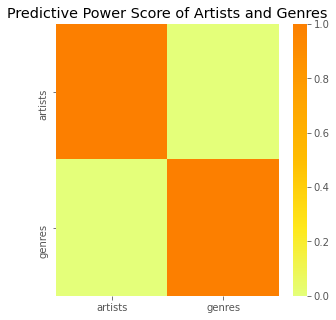

In [11]:
correlations = pps.matrix(df_known.reset_index()[["artists", "genres"]])

fig = plt.figure(figsize=(5, 5))
ax = fig.subplots()
sns.heatmap(pd.DataFrame(correlations["ppscore"].values.reshape(2, 2),
                         columns = ["artists", "genres"], index = ["artists", "genres"]),
                         cmap = "Wistia", axes = ax)
ax.set_title("Predictive Power Score of Artists and Genres")
plt.show()

### -> The artists feature isn't a good indicator (its predictive power score is nearly 0), so we cannot really predict genres by artists.

In [12]:
y_known.value_counts()[:25].to_dict()

{'pop': 638,
 'rock': 612,
 'dance pop': 570,
 'rap': 521,
 'hip hop': 514,
 'pop rap': 488,
 'pop rock': 462,
 'indie pop': 401,
 'country rock': 398,
 'folk rock': 394,
 'urban contemporary': 390,
 'latin': 389,
 'modern rock': 388,
 'southern hip hop': 377,
 'soft rock': 363,
 'trap': 361,
 'mellow gold': 358,
 'funk': 344,
 'roots rock': 336,
 'classic rock': 331,
 'album rock': 329,
 'adult standards': 327,
 'alternative rock': 324,
 'indie rock': 323,
 'gangster rap': 311}

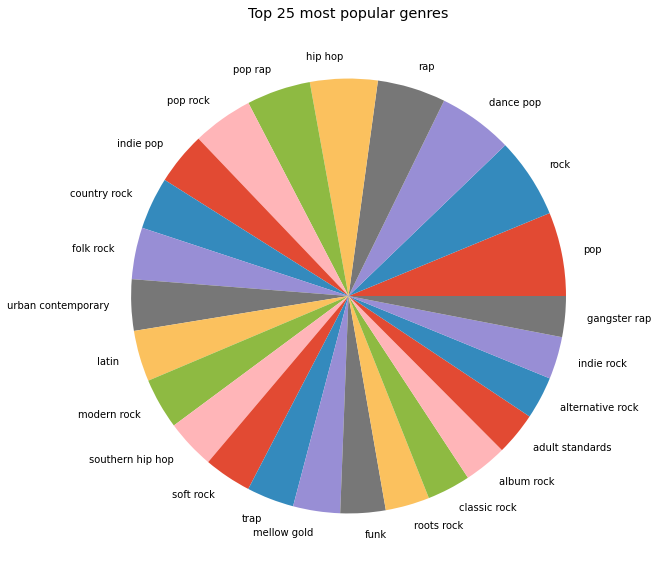

In [13]:
fig = plt.figure(figsize = (10, 10))
ax = fig.subplots()
y_known.value_counts()[:25].plot(ax=ax, kind = "pie")
ax.set_ylabel("")
ax.set_title("Top 25 most popular genres")
plt.show()

### -> There is a huge bias towards the most popular genres, especially Pop and Rock. In the following sections, we can increase the accuracy of missing data imputation with a simple yet clever trick: Only include the most popular ones!

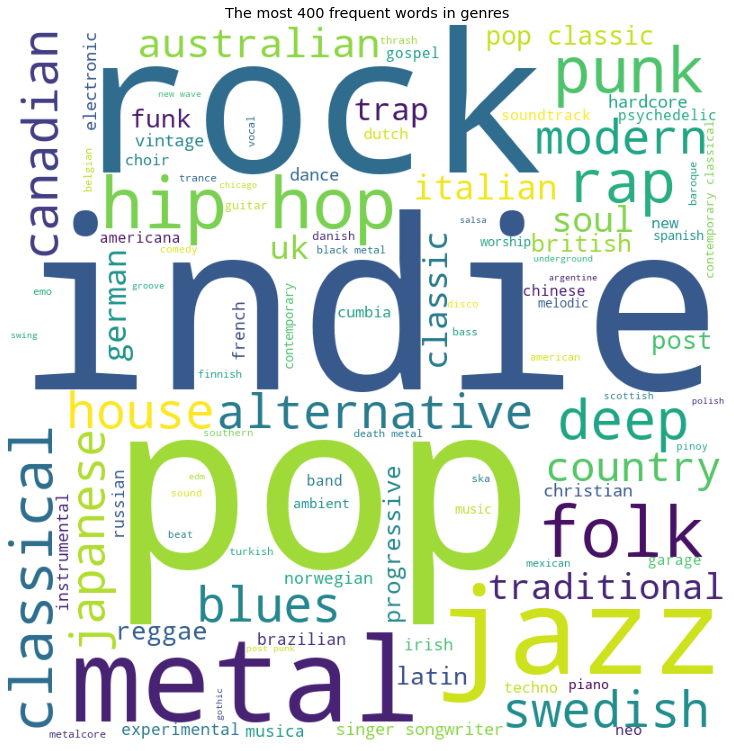

In [14]:
max_words = 400
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', max_words = max_words, colormap="viridis",
                min_font_size = 10).generate(" ".join(df.index))

plt.figure(figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.title(f"The most {max_words} frequent words in genres")
plt.show()

### -> The most frequent words are mostly words from the most popular genres. Pop and Rock, which are the top 2 most popular genres, are also the top 2 most frequent words, so we can conclude that there may be too many subgenres of these genres (e.g. Canadian Pop => Pop, Alternative Rock => Rock).

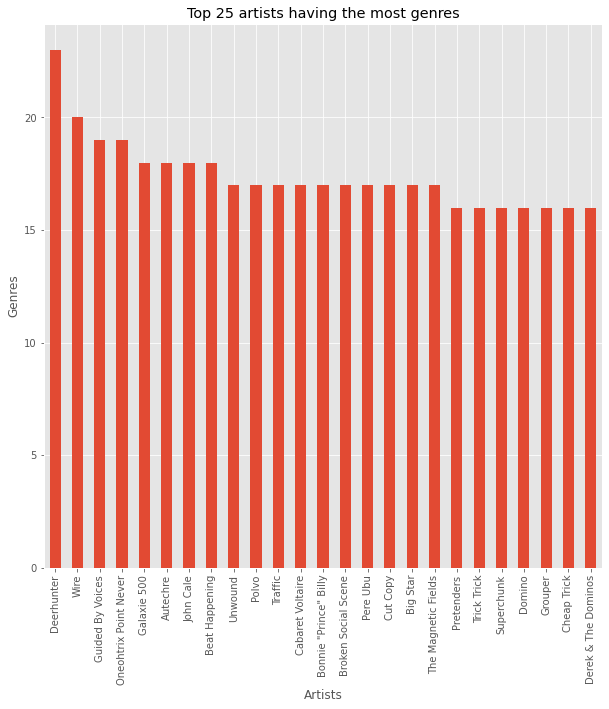

In [15]:
fig = plt.figure(figsize=(10, 10))
ax = fig.subplots()
ax.set_title("Top 25 artists having the most genres")
ax.set_ylabel("Genres")
ax.set_xlabel("Artists")
df_known["artists"].value_counts()[:25].plot(ax=ax, kind="bar")
plt.show()

### -> There are nearly 10k artists who do not have any genre at all, and there are artists who have too many genres (Deerhunter (23) followed by Wire(20)). The second type of artists are pretty rare, which leads to too much sparsity. That's why artists' predictive power score is too low. 

![](https://upload.wikimedia.org/wikipedia/commons/thumb/8/8a/Long_tail.svg/1200px-Long_tail.svg.png)

### -> Visualization of "Long Tail" phenomenon, X=number of genres, Y=number of artists

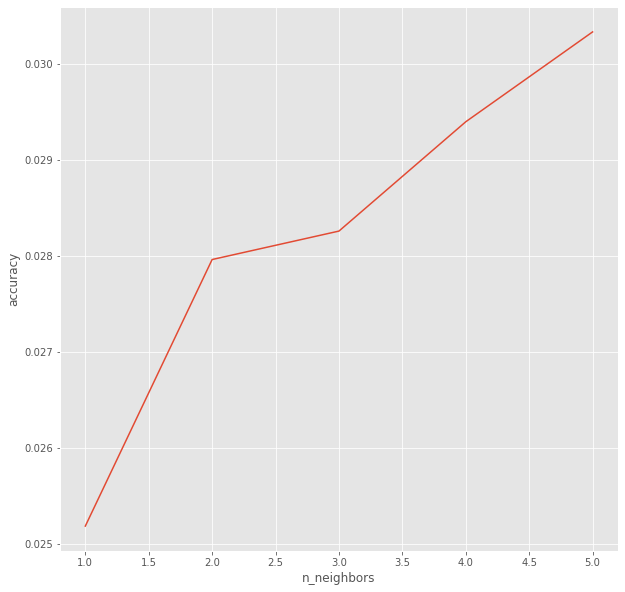

In [16]:
many_knn_score(1, 6, X_known, y_known)

### -> When we simply impute missing genres using KNN, it produces results with a very low accuracy score. The more neighbors are calculated, the more accurate the results are. N_neighbors = 100 => Acc = 0.04, N_neighbors = 500 => Acc = 0.06. The most probable reason it might be increasing is that the data in general is biased towards the most frequent genres. The solution is definitely gonna be including only the most popular genres. 

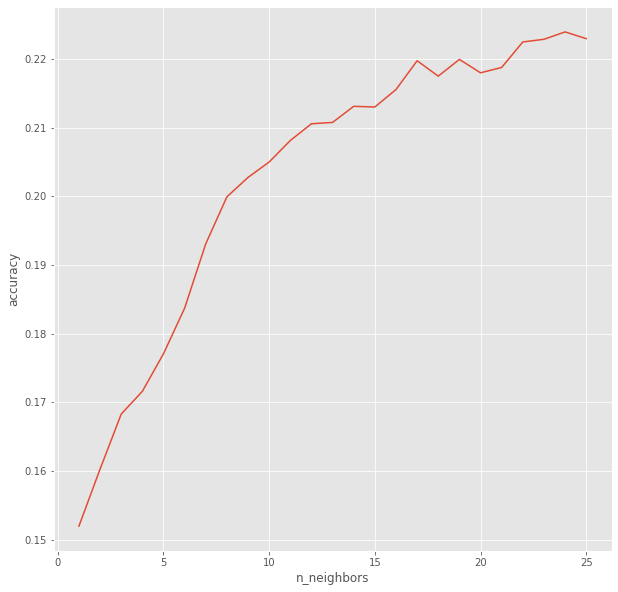

In [17]:
popular_genres = list(y_known.value_counts()[:25].index)
df_known_w_populars = df_known[df_known["genres"].isin(popular_genres)]
X_known_w_populars = df_known_w_populars[in_cols]
y_known_w_populars = df_known_w_populars["genres"]

many_knn_score(1, 26, X_known_w_populars, y_known_w_populars)

### -> When we only use the most popular genres in the knn imputing and increase the number of neighbors to 26, the performance rises to 0.22: What a great improvement! Let's increase the number of clusters!

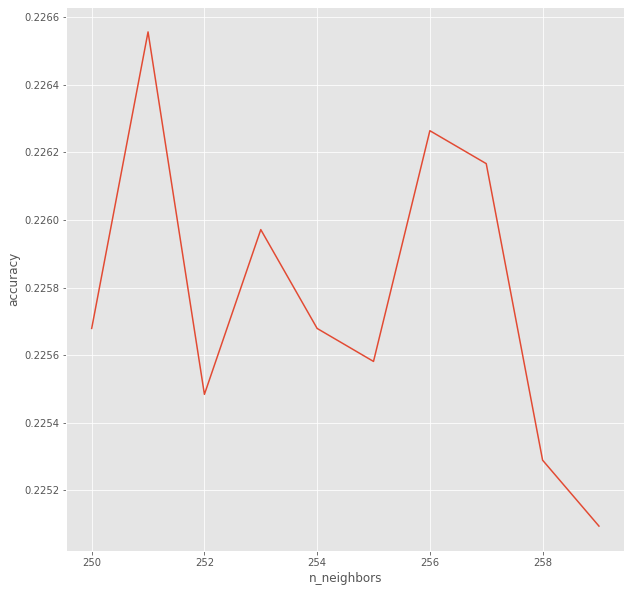

In [18]:
many_knn_score(250, 260, X_known_w_populars, y_known_w_populars)

### -> It looks like the accuracy does not improve any more... It is not a clever idea to impute missing genres because only 1 of 5 results is correct. 

In [19]:
genre_profile = df_known_w_populars[["genres", *in_cols]].groupby("genres").mean()
similarity_matrix=similarity_algorithm(X_known)

preds=list(similarity_matrix.index[similarity_matrix.values.argmax(axis=0)])

accuracy(preds, y_known)

0.004337514822442739

### -> As it turns out, cosine similarity isn't a good measurement for this specific purpose, as its accuracy score is the worst among others (5e-3). It is even worse than filling all missing genres with the most popular genre Pop, which results in 9e-3. By the way, it is time-consuming and requires too much memory.

In [20]:
genre_means, genre_stds = [], []
df_std = df.copy()
for col in in_cols:
    mean = df_std[col].mean()
    std = df_std[col].std()
    genre_means.append(mean)
    genre_stds.append(std)
    df_std[col] = (df_std[col] - mean) / std
df_std

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity
genres,,,,,,,,,,,
432hz,0.305215,-1.596574,8.825970,-0.501401,1.083396,-0.714143,-1.296810,-0.086290,0.081855,-1.404273,0.751718
a cappella,0.708935,0.272280,-0.615321,-0.962798,-0.765438,-0.758603,-0.479318,0.144528,-0.401501,-0.233259,0.201393
abstract,-0.126003,-0.518627,1.033595,-0.341770,2.306837,-0.845030,-0.743914,-0.502799,0.336159,-0.983097,0.085781
abstract beats,-0.145267,1.062287,-0.171843,0.213747,0.582693,-1.038482,0.735855,0.744773,0.031236,0.682567,1.153361
abstract hip hop,-0.614993,1.255655,-0.003264,0.354652,-0.769129,-0.293399,0.632521,2.074877,-0.381701,0.430615,0.229684
...,...,...,...,...,...,...,...,...,...,...,...
zolo,-0.574452,0.160211,0.200415,0.207529,-0.184741,-0.034802,-0.224901,-0.242461,0.252887,0.492915,-0.397414
zouglou,-0.875765,2.001816,0.505122,0.480079,-0.780257,-1.261777,-0.616399,-0.145114,0.010732,2.285573,0.991039
zouk,-0.528010,1.455071,0.504713,0.274564,0.394643,-1.256962,-0.097829,-0.569029,-0.979505,1.746104,0.146726


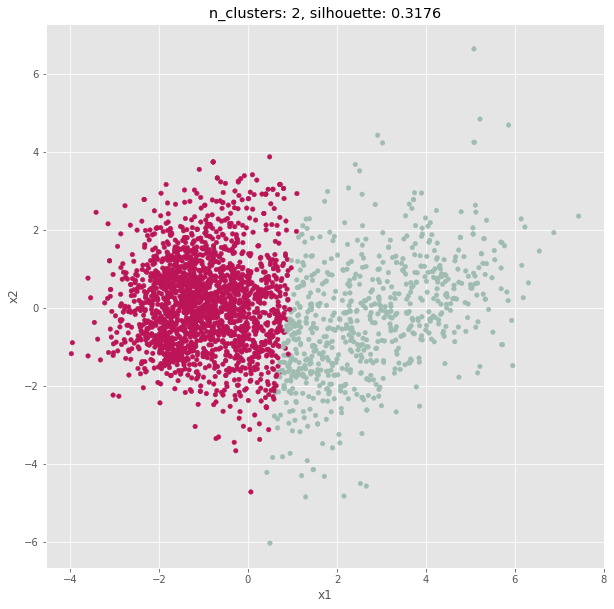

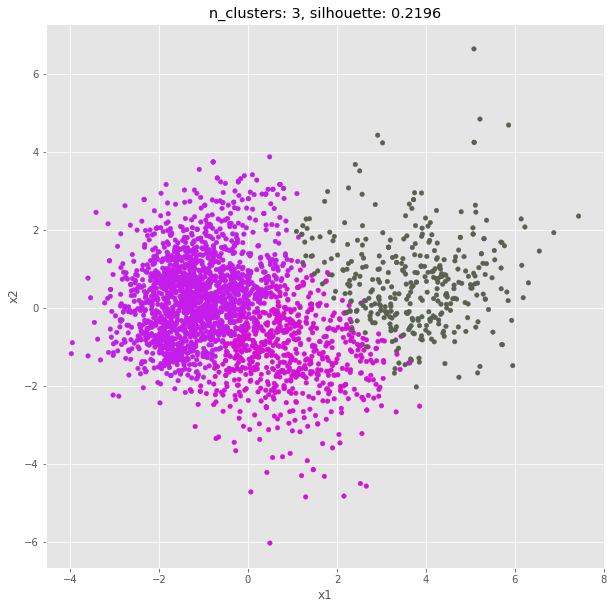

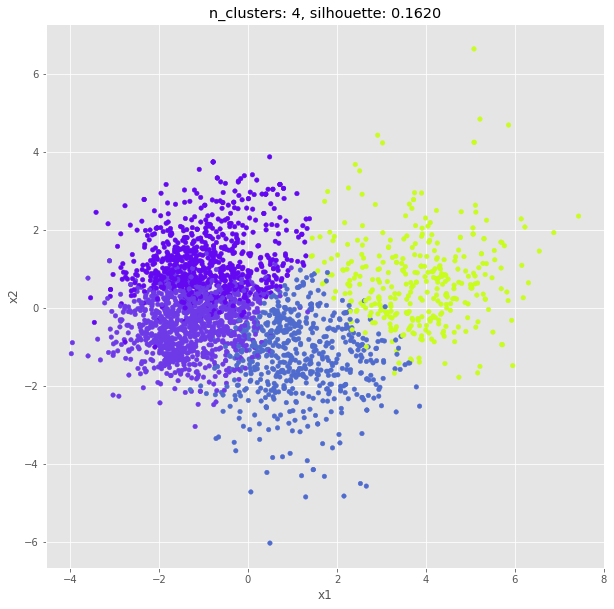

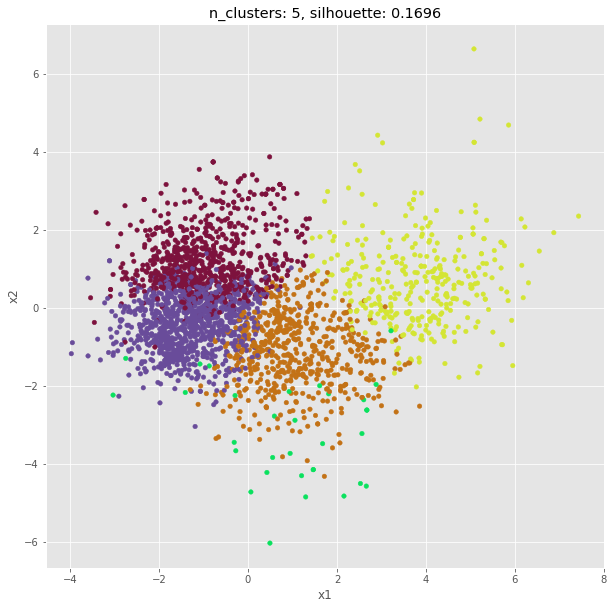

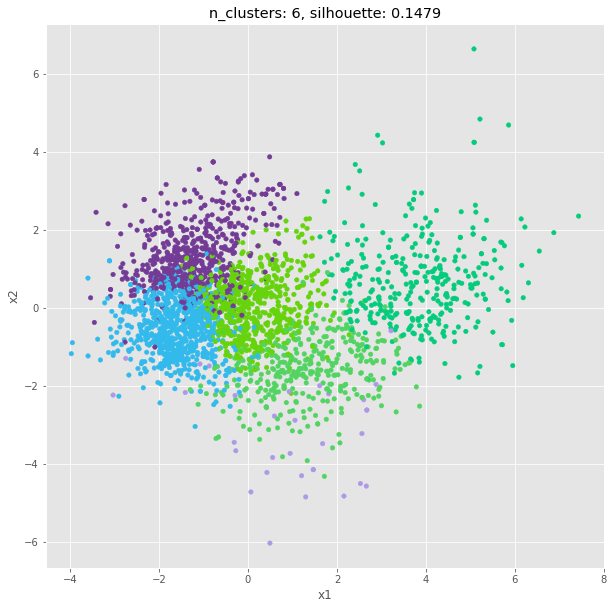

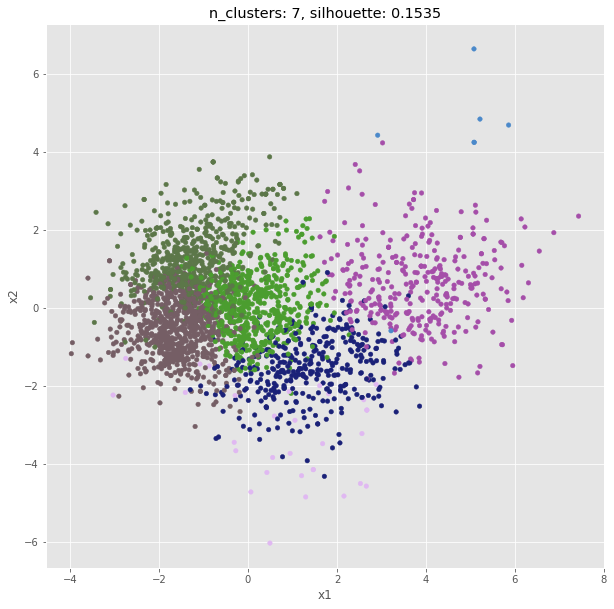

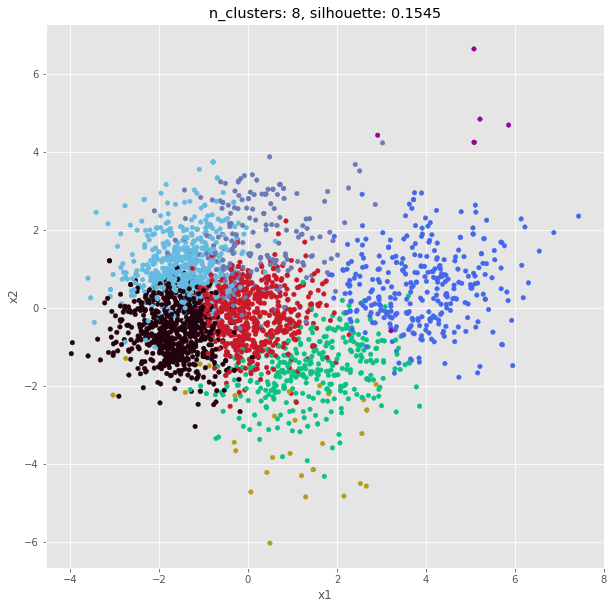

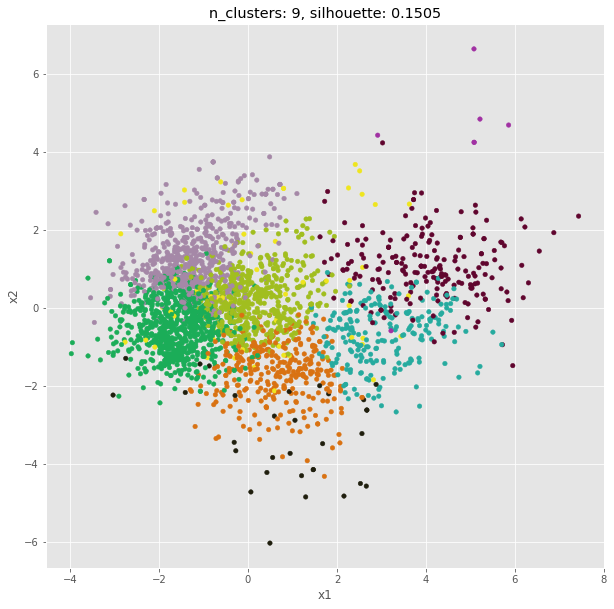

In [21]:
k_many_clusters(df_std, 2, 10)

### -> Observations: 
### ---> As the number of clusters increases, silhouette score decreases (N_clusters = 2 => Silhouette = 0.30, N_clusters = 9 => Silhouette = 0.15), which means the goodness of model decreases
### ---> One-Way ANOVA and T-Test are rejected due to the lack of at least one of the following assumptions:

### -------> T-Test: a) Normality, b) Different Means, c) No Correlation
### -------> One-Way ANOVA: a) Normality, b) Different Means, c) Equal Variance

### The data is not normally distributed, because in fact at the beginning we are transforming a multi-dimensional normal data into a single-dimensional non-normal data, which I believe it is to a certain extent not a huge deal-breaker at all. So let's do calculation!

In [22]:
i = 2
tester = Test(alpha = 0.05, only_result=False)
df_genre_profile = k_means(df_std, 2)[0]
ttest_result = tester.ttest(df_genre_profile[df_genre_profile["cluster"] == 0]["x1"].values, df_genre_profile[df_genre_profile["cluster"] == 1]["x1"].values)

ttest_result

{'power': 0.9,
 'alpha': 0.05,
 'n_req': 3,
 'n_control': 714,
 'n_test': 1949,
 'shapiro_control_stat': 0.9514012336730957,
 'shapiro_control_p': 1.3774021189578121e-14,
 'shapiro_test_stat': 0.9844116568565369,
 'shapiro_test_p': 6.728691346324922e-07,
 'pearsonr_stat': 0.0013209574448132455,
 'pearsonr_p': 0.9718922082613458,
 'ttest_stat': -58.28722474551535,
 'ttest_p': 0.0,
 'ind_limit': 0.2,
 'very_low_number': False,
 'control_is_normal': False,
 'test_is_normal': False,
 'very_low_correlation': True,
 'very_high_dependence': False,
 'no_difference': False,
 'test_is_bigger': False,
 'control_is_bigger': True,
 'test_is_accepted': False}

### -> Given that we pick 2 as the number of clusters, T-Test is rejected due to the lack of normality. Otherwise, the results indicate a very strong mean difference. (Group 1 has a lot bigger mean than Group 0)

In [23]:
anova_results = []
for i in range(2, 9):
    tester = Test(alpha=0.05, only_result=False)
    df_genre_profile = k_means(df_std, i)[0]
    test_data = [df_genre_profile[df_genre_profile["cluster"] == x]["x1"] for x in range(i)]
    anova_results.append(tester.anova(*test_data))
    
pd.DataFrame(anova_results)

,alpha,normality,levene_stat,levene_p,homogenity,anova_stat,anova_p,groups_are_different,test_is_accepted
0,0.05,False,234.721543,7.725671e-51,False,6129.835016,0.0,True,False
1,0.05,False,34.819260,1.182341e-15,False,4696.245455,0.0,True,False
2,0.05,False,21.592997,8.149622e-14,False,3232.348062,0.0,True,False
3,0.05,False,21.962821,7.421750e-18,False,2385.750230,0.0,True,False
4,0.05,False,51.106349,1.005688e-50,False,2456.443541,0.0,True,False
5,0.05,False,41.459488,1.526596e-48,False,2095.155178,0.0,True,False
6,0.05,False,38.864557,2.987136e-52,False,1978.660461,0.0,True,False


### -> Normality and homogenity are not fulfilled, so the test was rejected every time. However interestingly, the groups are always different. As the number of clusters increases, the mean difference decreases (6130 -> 1667), so picking a low number is a better option. The distribution is the most homogenous if the number of clusters is equal to 4 or 5 (levene-p is high and variance score is low). As you may notice in the plots above, 4 would be the best option! 

In [24]:
#predictions over new samples
#e.g. predict_cluster(df.iloc[:350])

#prediction over all data
{k: v for i, (k, v) in enumerate(predict_cluster(df).items()) if i%100==0}

{'432hz': 0,
 'argentine indie': 3,
 'baroque singing': 0,
 'brazilian punk': 1,
 'cancion melodica': 3,
 'christian power metal': 2,
 'comedy rap': 1,
 'dark cabaret': 2,
 'dixieland': 3,
 'enka': 3,
 'french metal': 2,
 'greek clarinet': 3,
 'icelandic experimental': 0,
 'italian gothic': 2,
 'jazz tuba': 3,
 'lilith': 1,
 'miami indie': 1,
 'naija worship': 2,
 'norwegian hip hop': 1,
 'panpipe': 0,
 'power-pop punk': 2,
 'riddim': 1,
 'sevdah': 1,
 'spanish renaissance': 0,
 'taiwan singer-songwriter': 3,
 'uk americana': 3,
 'vocal jazz': 3}

In [25]:
pred = predict_cluster(df)

df_known_new = df_known.copy()
df_known_new["cluster"] = df_known_new["genres"].map(lambda x: pred[x])

In [28]:
#artists - clusters (group by artists and find the most frequent clusters)
artists_clusters = df_known_new[["cluster", "artists"]].groupby("artists").agg(lambda x: x.value_counts().index[0])
artists_clusters["cluster"].value_counts(normalize=True)

2    0.504284
3    0.226687
0    0.153778
1    0.115251
Name: cluster, dtype: float64

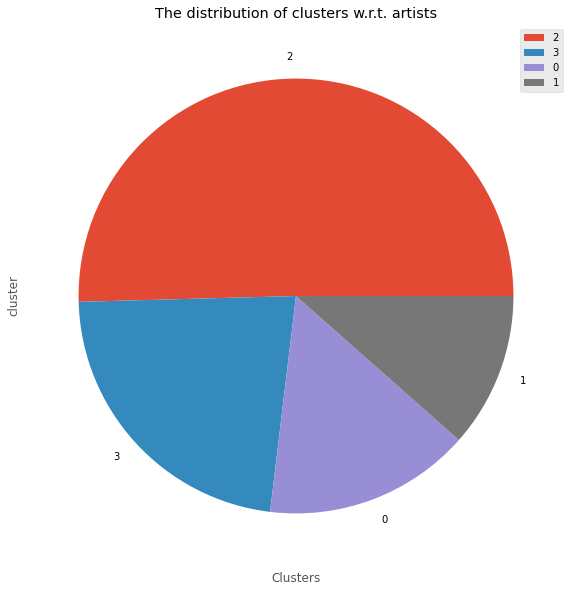

In [30]:
fig = plt.figure(figsize = (10, 10))
ax = fig.subplots()
ax.set_title("The distribution of clusters w.r.t. artists")
ax.set_xlabel("Clusters")
artists_clusters["cluster"].value_counts().plot(ax=ax, kind="pie",  legend=True)
plt.show()

### -> Distribution is nearly uniform, except for one cluster dominates nearly the half of artists.

In [33]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
create_cluster_name(artists_clusters)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\naren\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\naren\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


{'Cluster 0': 'black paul new',
 'Cluster 1': 'noise sounds rain',
 'Cluster 2': 'banda los lil',
 'Cluster 3': 'los john johnny'}

### -> Machine-generated names for possible genre groups. It is created by picking the top 3 most frequent words in the names of artists which are not stopwords like "the" or "a", and ordering them randomly. Can you see how amazing it is!

# Conclusion

### -> The data is biased towards the most popular genres, mostly Pop and Rock, and which is why it is more difficult to predict less popular genres. 
### ---> Suggestion: Try over- or undersampling. 

### -> The imputing seems to work poorly both for K-Nearest Neighbors and Cosine Similarity Matcher.

### ---> Suggestion: Play around with the KNN hyperparameters such as distance criterion. Try a neural network regressor with tuned hyperparameters, maybe MissForest imputer or even a NLP classifier which analyzes the artists' names. If it goes well, impute data and repeat the analysis.
### ---> Hint: Classification results will be more accurate, as only the most popular genres are included in the labels. With this clever trick, the performance of has increased from 2-3%s to 22-23%s! (n_clusters in 2-9 interval)

### -> Both silhouette scores are too low and we can not prove significant group differences, which is why K-Means Clustering didn't work as expected.
### ---> Suggestion: Play around with the hyperparameters in K-Means model (e.g. set distance criterion to "weighted" instead of "uniform"(default))or try other clustering algorithms such as DBSCAN and Mean Shift.

### -> According to statistical tests, the most suitable pick for number of clusters is 4.

# The ball is on your court, try it yourself. By the way, don't forget to upvote my notebook :)